In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt
import triton
import triton.language as tl
import triton.testing

In [3]:
@triton.jit
def gqa_forward(
    q_ptr, k_ptr, v_ptr, o_ptr,
    batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    scale,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
):
    batch_id = tl.program_id(0)
    q_head_id = tl.program_id(1)
    m_id = tl.program_id(2)

    # Mapping query head to corresponding KV head
    kv_head_id = q_head_id // (num_q_heads // num_kv_heads)

    # Starting row index
    start_m = m_id * BLOCK_SIZE_M

    # Offsets for Q
    q_batch_offset = batch_id * q_batch_stride
    q_head_offset = q_head_id * q_head_stride

    # Offsets for K and V - uses kv_head_id instead of query head id in flash attention
    k_batch_offset = batch_id * k_batch_stride
    k_head_offset = kv_head_id * k_head_stride
    v_batch_offset = batch_id * v_batch_stride
    v_head_offset = kv_head_id * v_head_stride

    # Offset for output
    o_batch_offset = batch_id * o_batch_stride
    o_head_offset = q_head_id * o_head_stride

    # Initialize accumulators
    m_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_K], dtype=tl.float32)

    # Create row indices and mask
    row_indices = start_m + tl.arange(0, BLOCK_SIZE_M)
    row_mask = row_indices < seq_len

    # Loading Q block once - I'll reuse it for all K,V blocks
    q_block = tl.load(
        q_ptr + q_batch_offset + q_head_offset +
        row_indices[:, None] * q_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * q_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Process blocks of K and V
    for start_n in range(0, seq_len, BLOCK_SIZE_N):
        col_indices = start_n + tl.arange(0, BLOCK_SIZE_N)
        col_mask = col_indices < seq_len

        if IS_CAUSAL:
            causal_mask = row_indices[:, None] >= col_indices[None, :]

        # Loading K block - using kv_head_id
        k_block = tl.load(
            k_ptr + k_batch_offset + k_head_offset +
            col_indices[:, None] * k_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * k_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        scores = tl.dot(q_block, tl.trans(k_block)) * scale

        if IS_CAUSAL:
            scores = tl.where(causal_mask, scores, float('-inf'))

        # Compute new max for stable softmax
        m_i_new = tl.maximum(m_i, tl.max(scores, axis=1))
        alpha = tl.exp(m_i - m_i_new)

        # Update max values
        m_i = m_i_new

        # Compute softmax values with updated max
        p = tl.exp(scores - m_i[:, None])

        # Load V block - using kv_head_id
        v_block = tl.load(
            v_ptr + v_batch_offset + v_head_offset +
            col_indices[:, None] * v_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * v_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        # Update sum of exponentials
        l_i_new = alpha * l_i + tl.sum(p, axis=1)

        # Update weighted sum
        acc_new = alpha[:, None] * acc + tl.dot(p, v_block)

        # Update accumulators
        l_i = l_i_new
        acc = acc_new

    m_ptr = o_ptr + seq_len * head_dim * num_q_heads * head_dim
    l_ptr = m_ptr + seq_len * head_dim * num_q_heads

    # Store M and L values (one per query)
    tl.store(
        m_ptr + batch_id * (num_q_heads * seq_len) + q_head_id * seq_len + row_indices,
        m_i,
        mask=row_mask
    )

    tl.store(
        l_ptr + batch_id * (num_q_heads * seq_len) + q_head_id * seq_len + row_indices,
        l_i,
        mask=row_mask
    )

    out = acc / l_i[:, None]

    tl.store(
        o_ptr + o_batch_offset + o_head_offset +
        row_indices[:, None] * o_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * o_head_dim_stride,
        out,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

### Computing D = rowsum(O * dO)

In [4]:
@triton.jit
def gqa_backward_preprocess(
    o_ptr, do_ptr, d_ptr,
    batch_size, seq_len, num_q_heads, head_dim,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    do_batch_stride, do_head_stride, do_seq_stride, do_head_dim_stride,
    BLOCK_SIZE: tl.constexpr
):
    """
    Preprocess for backward pass: Compute D = rowsum(O * dO)
    """
    batch_id = tl.program_id(0)
    q_head_id = tl.program_id(1)
    block_id = tl.program_id(2)

    start_idx = block_id * BLOCK_SIZE
    row_indices = start_idx + tl.arange(0, BLOCK_SIZE)
    row_mask = row_indices < seq_len

    o_batch_offset = batch_id * o_batch_stride
    o_head_offset = q_head_id * o_head_stride

    do_batch_offset = batch_id * do_batch_stride
    do_head_offset = q_head_id * do_head_stride

    # Load in the O block and dO block
    o_block = tl.load(
        o_ptr + o_batch_offset + o_head_offset +
        row_indices[:, None] * o_seq_stride +
        tl.arange(0, head_dim)[None, :] * o_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, head_dim)[None, :] < head_dim),
        other=0.0
    )

    do_block = tl.load(
        do_ptr + do_batch_offset + do_head_offset +
        row_indices[:, None] * do_seq_stride +
        tl.arange(0, head_dim)[None, :] * do_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, head_dim)[None, :] < head_dim),
        other=0.0
    )

    d_block = tl.sum(o_block * do_block, axis=1)

    # Per query head
    d_offset = batch_id * (num_q_heads * seq_len) + q_head_id * seq_len

    tl.store(d_ptr + d_offset + row_indices, d_block, mask=row_mask)

### Computing dQ

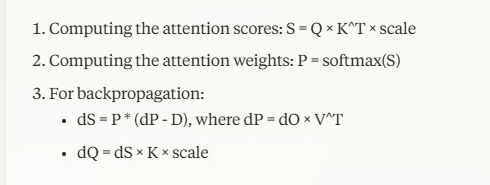

In [5]:
@triton.jit
def gqa_backward_dq(
    q_ptr, k_ptr, v_ptr, o_ptr, do_ptr, dq_ptr,
    m_ptr, l_ptr, d_ptr,
    batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    do_batch_stride, do_head_stride, do_seq_stride, do_head_dim_stride,
    dq_batch_stride, dq_head_stride, dq_seq_stride, dq_head_dim_stride,
    scale,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
):
    """
    Compute dQ for Flash Attention V2 backward pass with GQA support
    """
    batch_id = tl.program_id(0)
    q_head_id = tl.program_id(1)
    m_id = tl.program_id(2)

    # Map query head to corresponding KV head
    kv_head_id = q_head_id // (num_q_heads // num_kv_heads)

    # Starting row index
    start_m = m_id * BLOCK_SIZE_M
    row_indices = start_m + tl.arange(0, BLOCK_SIZE_M)
    row_mask = row_indices < seq_len

    # Query offsets
    q_batch_offset = batch_id * q_batch_stride
    q_head_offset = q_head_id * q_head_stride

    # KV offsets - using kv_head_id
    k_batch_offset = batch_id * k_batch_stride
    k_head_offset = kv_head_id * k_head_stride
    v_batch_offset = batch_id * v_batch_stride
    v_head_offset = kv_head_id * v_head_stride

    # Gradient offsets
    do_batch_offset = batch_id * do_batch_stride
    do_head_offset = q_head_id * do_head_stride
    dq_batch_offset = batch_id * dq_batch_stride
    dq_head_offset = q_head_id * dq_head_stride

    # Get the m, l, and d values for these rows
    m_offset = batch_id * (num_q_heads * seq_len) + q_head_id * seq_len
    m_i = tl.load(
        m_ptr + m_offset + row_indices,
        mask=row_mask,
        other=float("-inf")
    )
    l_i = tl.load(
        l_ptr + m_offset + row_indices,
        mask=row_mask,
        other=0.0
    )
    d_i = tl.load(
        d_ptr + m_offset + row_indices,
        mask=row_mask,
        other=0.0
    )

    # Load Q block for this set of queries
    q_block = tl.load(
        q_ptr + q_batch_offset + q_head_offset +
        row_indices[:, None] * q_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * q_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Load dO block for this set of queries
    do_block = tl.load(
        do_ptr + do_batch_offset + do_head_offset +
        row_indices[:, None] * do_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * do_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Initialize dQ accumulator
    dq_block = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_K], dtype=tl.float32)

    # Process KV blocks
    for start_n in range(0, seq_len, BLOCK_SIZE_N):
        col_indices = start_n + tl.arange(0, BLOCK_SIZE_N)
        col_mask = col_indices < seq_len

        if IS_CAUSAL:
            causal_mask = row_indices[:, None] >= col_indices[None, :]

        # Load K block - using kv_head_id
        k_block = tl.load(
            k_ptr + k_batch_offset + k_head_offset +
            col_indices[:, None] * k_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * k_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        # Load V block - using kv_head_id
        v_block = tl.load(
            v_ptr + v_batch_offset + v_head_offset +
            col_indices[:, None] * v_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * v_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        # Compute attention scores
        scores = tl.dot(q_block, tl.trans(k_block)) * scale

        if IS_CAUSAL:
            scores = tl.where(causal_mask, scores, float('-inf'))

        # Compute P = softmax(QK^T)
        p = tl.exp(scores - m_i[:, None])

        # Compute dp = dO @ V^T
        dp = tl.dot(do_block, tl.trans(v_block))

        # Compute dS = P * (dp - d_i)
        ds = p * (dp - d_i[:, None])

        # Update dQ accumulator
        dq_block += tl.dot(ds, k_block) * scale

    # Store dQ block
    tl.store(
        dq_ptr + dq_batch_offset + dq_head_offset +
        row_indices[:, None] * dq_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * dq_head_dim_stride,
        dq_block,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

Here we need to consider all the query blocks using a particular KV block. This is a major difference compared to convential MHA or flash attention

In [6]:
@triton.jit
def gqa_backward_dkv(
    q_ptr, k_ptr, v_ptr, o_ptr, do_ptr, dk_ptr, dv_ptr,
    m_ptr, l_ptr, d_ptr,
    batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    do_batch_stride, do_head_stride, do_seq_stride, do_head_dim_stride,
    dk_batch_stride, dk_head_stride, dk_seq_stride, dk_head_dim_stride,
    dv_batch_stride, dv_head_stride, dv_seq_stride, dv_head_dim_stride,
    scale,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
    KV_GROUP_SIZE: tl.constexpr # Number of query tokens sharing a given KV head
):
    """
    Compute dK and dV for Flash Attention V2 backward pass with GQA support
    """
    batch_id = tl.program_id(0)
    kv_head_id = tl.program_id(1)  # This is the KV head ID
    n_id = tl.program_id(2)

    start_n = n_id * BLOCK_SIZE_N
    col_indices = start_n + tl.arange(0, BLOCK_SIZE_N)
    col_mask = col_indices < seq_len

    # Each KV head is shared by KV_GROUP_SIZE query heads
    # Calculate the starting and ending query head indices for this KV head
    q_head_start = kv_head_id * KV_GROUP_SIZE
    q_head_end = (kv_head_id + 1) * KV_GROUP_SIZE

    # KV offsets
    k_batch_offset = batch_id * k_batch_stride
    k_head_offset = kv_head_id * k_head_stride
    v_batch_offset = batch_id * v_batch_stride
    v_head_offset = kv_head_id * v_head_stride

    # Gradient offsets
    dk_batch_offset = batch_id * dk_batch_stride
    dk_head_offset = kv_head_id * dk_head_stride
    dv_batch_offset = batch_id * dv_batch_stride
    dv_head_offset = kv_head_id * dv_head_stride

    # Initializing dk and dv
    dk_block = tl.zeros([BLOCK_SIZE_N, BLOCK_SIZE_K], dtype=tl.float32)
    dv_block = tl.zeros([BLOCK_SIZE_N, BLOCK_SIZE_K], dtype=tl.float32)

    # Loading in K and V blocks
    k_block = tl.load(
        k_ptr + k_batch_offset + k_head_offset +
        col_indices[:, None] * k_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * k_head_dim_stride,
        mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    v_block = tl.load(
        v_ptr + v_batch_offset + v_head_offset +
        col_indices[:, None] * v_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * v_head_dim_stride,
        mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Loop through all query heads that share this KV head, This loop doesn't exist for multi head attention
    for q_head_id in range(q_head_start, q_head_end):
        if q_head_id >= num_q_heads:
            continue

        q_head_offset = q_head_id * q_head_stride
        do_head_offset = q_head_id * do_head_stride

        offset_ml = batch_id * (num_q_heads * seq_len) + q_head_id * seq_len

        # Process Q Blocks
        for start_m in range(0, seq_len, BLOCK_SIZE_M):
            row_indices = start_m + tl.arange(0, BLOCK_SIZE_M)
            row_mask = row_indices < seq_len

            if IS_CAUSAL:
                causal_mask = row_indices[:, None] >= col_indices[None, :]

            # Load Q block for this query head
            q_block = tl.load(
                q_ptr + batch_id * q_batch_stride + q_head_offset +
                row_indices[:, None] * q_seq_stride +
                tl.arange(0, BLOCK_SIZE_K)[None, :] * q_head_dim_stride,
                mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
                other=0.0
            )

            # Load dO block for this query head
            do_block = tl.load(
                do_ptr + batch_id * do_batch_stride + do_head_offset +
                row_indices[:, None] * do_seq_stride +
                tl.arange(0, BLOCK_SIZE_K)[None, :] * do_head_dim_stride,
                mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
                other=0.0
            )

            # Load M, L, D values for this query head
            m_i = tl.load(
                m_ptr + offset_ml + row_indices,
                mask=row_mask,
                other=float("-inf")
            )

            d_i = tl.load(
                d_ptr + offset_ml + row_indices,
                mask=row_mask,
                other=0.0
            )

            # Compute KQ^T (transposed attention scores)
            qk_t = tl.dot(k_block, tl.trans(q_block)) * scale

            if IS_CAUSAL:
                causal_mask_t = tl.trans(causal_mask)
                qk_t = tl.where(causal_mask_t, qk_t, float('-inf'))

            # Compute P^T = softmax(KQ^T)
            p_t = tl.exp(qk_t - m_i[None, :])

            # dV = P^T @ dO (accumulate for this query head)
            dv_block += tl.dot(p_t, do_block)

            # dp^T = V @ dO^T
            dp_t = tl.dot(v_block, tl.trans(do_block))

            # Compute dS^T = P^T * (dP^T - D^T)
            ds_t = p_t * (dp_t - d_i[None, :])

            # Update dK += dS^T @ Q (accumulate for this query head)
            dk_block += tl.dot(ds_t, q_block) * scale

    # Store accumulated dK and dV for this KV head
    tl.store(
        dk_ptr + dk_batch_offset + dk_head_offset +
        col_indices[:, None] * dk_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * dk_head_dim_stride,
        dk_block,
        mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

    tl.store(
        dv_ptr + dv_batch_offset + dv_head_offset +
        col_indices[:, None] * dv_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * dv_head_dim_stride,
        dv_block,
        mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

In [7]:
class GroupedQueryAttention(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, scale, causal, block_size):
        # Get dimensions
        batch_size, num_q_heads, seq_len, head_dim = q.shape
        _, num_kv_heads, _, _ = k.shape  # KV has fewer heads than Q

        # Number of query heads per key/value head
        kv_group_size = num_q_heads // num_kv_heads

        # Create output tensor
        o = torch.empty_like(q)

        # Allocate memory for M and L (needed for backward pass)
        # M and L are per (batch, query_head, query)
        m = torch.empty((batch_size, num_q_heads, seq_len), device=q.device, dtype=torch.float32)
        l = torch.empty((batch_size, num_q_heads, seq_len), device=q.device, dtype=torch.float32)

        grid = (batch_size, num_q_heads, triton.cdiv(seq_len, block_size))

        # Round head_dim up to the nearest power of 2 if needed
        block_k = head_dim
        if block_k & (block_k - 1) != 0:
            block_k = 1
            while block_k < head_dim:
                block_k *= 2

        # Launch forward kernel with GQA support
        gqa_forward[grid](
            q, k, v, o,
            batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,  # Added num_kv_heads
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            scale,
            BLOCK_SIZE_M=block_size,
            BLOCK_SIZE_N=block_size,
            BLOCK_SIZE_K=block_k,
            IS_CAUSAL=causal,
        )

        # Save for backward
        ctx.save_for_backward(q, k, v, o, m, l)
        ctx.scale = scale
        ctx.causal = causal
        ctx.block_size = block_size
        ctx.num_q_heads = num_q_heads
        ctx.num_kv_heads = num_kv_heads

        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, m, l = ctx.saved_tensors
        scale = ctx.scale
        causal = ctx.causal
        block_size = ctx.block_size
        num_q_heads = ctx.num_q_heads
        num_kv_heads = ctx.num_kv_heads

        # Get dimensions
        batch_size, _, seq_len, head_dim = q.shape
        kv_group_size = num_q_heads // num_kv_heads

        # Initialize gradients
        dq = torch.zeros_like(q)
        dk = torch.zeros_like(k)
        dv = torch.zeros_like(v)

        # Ensure do is contiguous
        do = do.contiguous()

        # Allocate memory for D (rowsum(dO * O)) - for each query head
        d = torch.empty((batch_size, num_q_heads, seq_len), device=q.device, dtype=torch.float32)

        # Round head_dim up to the nearest power of 2 if needed
        block_k = head_dim
        if block_k & (block_k - 1) != 0:
            block_k = 1
            while block_k < head_dim:
                block_k *= 2

        # Grid for preprocessing - one per query head
        grid_preprocess = (batch_size, num_q_heads, triton.cdiv(seq_len, block_size))

        # Preprocess: Compute D = rowsum(dO * O) for each query head
        gqa_backward_preprocess[grid_preprocess](
            o, do, d,
            batch_size, seq_len, num_q_heads, head_dim,
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            do.stride(0), do.stride(1), do.stride(2), do.stride(3),
            BLOCK_SIZE=block_size,
        )

        # Grid for dQ computation - iterate through Q blocks, one per query head
        grid_dq = (batch_size, num_q_heads, triton.cdiv(seq_len, block_size))

        # Compute dQ
        gqa_backward_dq[grid_dq](
            q, k, v, o, do, dq,
            m, l, d,
            batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            do.stride(0), do.stride(1), do.stride(2), do.stride(3),
            dq.stride(0), dq.stride(1), dq.stride(2), dq.stride(3),
            scale,
            BLOCK_SIZE_M=block_size,
            BLOCK_SIZE_N=block_size,
            BLOCK_SIZE_K=block_k,
            IS_CAUSAL=causal,
        )

        # Grid for dK, dV computation - iterate through K,V blocks, one per KV head
        grid_dkv = (batch_size, num_kv_heads, triton.cdiv(seq_len, block_size))

        # Compute dK and dV with GQA support
        gqa_backward_dkv[grid_dkv](
            q, k, v, o, do, dk, dv,
            m, l, d,
            batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            do.stride(0), do.stride(1), do.stride(2), do.stride(3),
            dk.stride(0), dk.stride(1), dk.stride(2), dk.stride(3),
            dv.stride(0), dv.stride(1), dv.stride(2), dv.stride(3),
            scale,
            BLOCK_SIZE_M=block_size,
            BLOCK_SIZE_N=block_size,
            BLOCK_SIZE_K=block_k,
            IS_CAUSAL=causal,
            KV_GROUP_SIZE=kv_group_size,
        )

        # Return gradients
        return dq, dk, dv, None, None, None